# Assignment 1

## Piotr Zawiła-Niedźwiecki


### Exercise 1:
#### The file aa-rv-20m.txt contains the realised daily volatility series of Alcoa stock returns from January 2, 2003 - May 7, 2004 based on 20-minute intradaily log returns.

#### a) Fit an ARIMA(0,1,1) model of the log volatility series and write down the model.

In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima_model import ARMA

First 5 observations of alcoa_stock_data:       values
0     3.0692
1     6.7121
2     0.5711
3     2.1220
4    14.5181


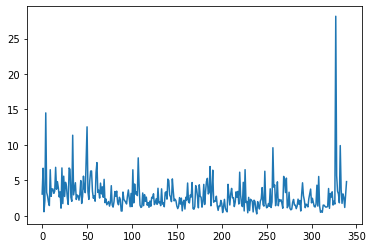

In [256]:
alcoa_stock_data = pd.read_csv(r"C:\Users\zawilaniedzwiecki.p\OneDrive - Procter and Gamble\Desktop\alcoa_stock_series.csv")

print(f"First 5 observations of alcoa_stock_data: {alcoa_stock_data[:5]}")
plt.plot(alcoa_stock_data)
plt.show()

First 5 observations of log_alcoa_stock_data:       values
0   1.121417
1   1.903912
2  -0.560191
3   0.752359
4   2.675396


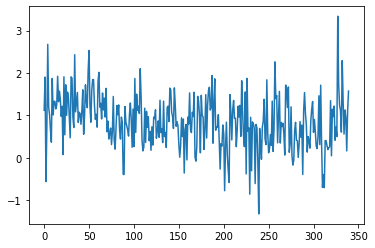

In [257]:
log_alcoa_stock_data = np.log(alcoa_stock_data)

print(f"First 5 observations of log_alcoa_stock_data: {log_alcoa_stock_data[:5]}")
plt.plot(log_alcoa_stock_data)
plt.show()

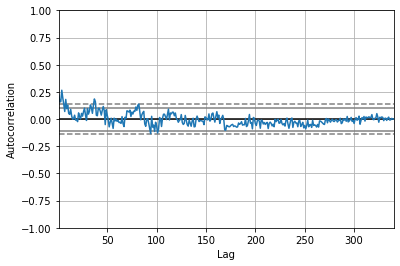

In [258]:
autocorrelation_plot(log_alcoa_stock_data)
plt.show()

In [20]:
arima_model = ARIMA(log_alcoa_stock_data, order = (0,1,1))
fitted_arima_model = arima_model.fit()
print(fitted_arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.   values   No. Observations:                  339
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -310.060
Method:                       css-mle   S.D. of innovations              0.603
Date:                Sun, 24 May 2020   AIC                            626.119
Time:                        12:53:17   BIC                            637.597
Sample:                             1   HQIC                           630.693
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0002      0.004     -0.053      0.958      -0.008       0.008
ma.L1.D.   values    -0.8750      0.041    -21.435      0.000      -0.955      -0.795
                        

#### b) Estimate the local trend model, of the form:

#### y_t = mu_t + e_t where e_t ~ N(0, sigma_e^2)

#### #### mu_t+1 = mu_t + eta_t where eta_t ~ N(0, sigma_eta^2)

#### For the log volatility series. What are the estimates of standard deviations. Obtain time plots for the filtered and smoothed state space variables with pointwise 95% confidence interval.

I will obtain the estimation of std, by creating my own class of Local Trend models that will inherit from statsmodels statespace MLE models. 

Worth noting is the initialization of matrices. Parameters self.ssm[] will be used later during matrix multiplication to estimate further states and parameters of the model.

In here those represent matrix computations of: 

y_t = (1) * (mu_t) + noise

mu_t+1 = mu_t + noise

In [38]:
class LocalTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 1

        # Initialize the statespace
        super(LocalTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1])
        self.ssm['transition'] = np.array([1])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.e', 'sigma2.eta']

    @property
    def start_params(self):
        return [np.std(self.endog)]*2

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalTrend, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

In [39]:
local_trend_model = LocalTrend(log_alcoa_stock_data)
fitted_local_trend_model = local_trend_model.fit()

In [40]:
print(fitted_local_trend_model.summary())

                           Statespace Model Results                           
Dep. Variable:                 values   No. Observations:                  340
Model:                     LocalTrend   Log Likelihood                -310.061
Date:                Sun, 24 May 2020   AIC                            624.122
Time:                        13:13:08   BIC                            631.774
Sample:                             0   HQIC                           627.171
                                - 340                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2.e       0.3177      0.024     13.372      0.000       0.271       0.364
sigma2.eta     0.0057      0.003      2.230      0.026       0.001       0.011
Ljung-Box (Q):                       52.21   Jarque-

Having estimates of variance, we can get fitted values of state variables (in this case those are the smoothed values), and plot their confidence intervals using sigma2.eta

In [184]:
state_params = fitted_local_trend_model.filter_results.filtered_state[0]
print(state_params[:5])
state_params_index = np.arange(len(state_params))

[1.12141659 1.51613539 0.80371419 0.7900919  1.20612931]


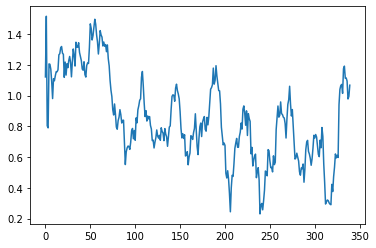

In [185]:
plt.plot(state_params, label = "state_params")
plt.show()

Unfortunately I didn't know how to add CI for the state variable in this case. Maybe R implementation has out of the box function, but I couldn't figure out a way in Python :(.

Let's plot the observed variables with their conf_int now

In [55]:
predict = fitted_local_trend_model.get_prediction()
predict_ci = predict.conf_int(alpha=0.05)
predict_index = np.arange(len(predict_ci))

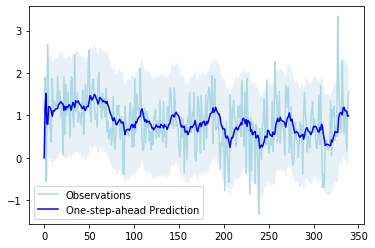

In [96]:
plt.plot(log_alcoa_stock_data, label = "Observations", color = "lightblue")
plt.fill_between(predict_index[2:], predict_ci.iloc[2:,0], predict_ci.iloc[2:,1], alpha = 0.1)
plt.plot(predict.predicted_mean, label = "One-step-ahead Prediction", color = "blue")
plt.legend(loc = "lower left")
plt.show()

### Exercise 2:
#### Consider the monthly simple excess returns of Pfizer stock and the S&P 500 composite index from January 1990 to December 2003. The excess returns are in m-pf eps-ex9003.txt with Pfizer stock returns in the first column.

#### a) Fit a fixed-coefficient market model to the Pfizer stock returns. Write down the fitted model.

I assume that by fixed-coefficient market model, we mean linear model. Therefore I will fit linear regression model to data.

In [147]:
pfizer_stock_data = pd.read_csv(r"C:\Users\zawilaniedzwiecki.p\OneDrive - Procter and Gamble\Desktop\pfizer_stock_series.csv", dtype = np.float32)

In [148]:
pfizer_stock_data.head()

,returns
0,-0.02076
1,-0.13638
2,0.02096
3,-0.07040
4,0.16492


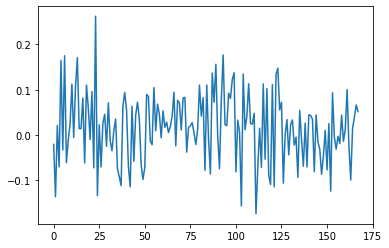

In [151]:
plt.plot(pfizer_stock_data["returns"])
plt.show()

As we can clearly see, fixed linear model will be horrendously wrong.

In [155]:
constant_vector = [1]*len(pfizer_stock_data)

ols_model = OLS(pfizer_stock_data, constant_vector)
fitted_ols_model = ols_model.fit()
print(fitted_ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 24 May 2020   Prob (F-statistic):                nan
Time:                        14:28:07   Log-Likelihood:                 195.46
No. Observations:                 168   AIC:                            -388.9
Df Residuals:                     167   BIC:                            -385.8
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0158      0.006      2.693      0.0

R-squared of 0.000 sums this approach pretty adequately :).

#### b) Express a time-varying CAPM as a state space model and fit a CAPM to the Pfizer stock return. This is a model of the form:

#### r_t = alpha_t + Beta_t * r_M,t + e_t where e_t ~ N(0,sigma_e^2)

#### alpha_t+1 = alpha_t + eta_t where eta_t ~ N(0,sigma_eta^2)

#### Beta_t+1 = Beta_t + eps_t where eps_t ~ N(0,sigma_eps^2)

#### Here r_t is the excess return of an asset, while r_M,t is the excess return of the market. The S&P returns are used for the market.

#### What are the estimated standard erros of the innovations to the alpha_t and Beta_t series? Obtain time plots of the smoothed stimates of alpha_t and Beta_t.

I will again implement python class, purely for this excercise.

I will let myself to initialize r_mt as any value, as leaving it as one resulted in convergence problems.

In [198]:
class CAPM(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, r_mt):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(CAPM, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1, r_mt])
        self.ssm['transition'] = np.array([[1, 0],
                                       [0, 1]])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.e', 'sigma2.eta', 'sigma2.eps']

    @property
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(CAPM, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

In [199]:
r_mt = 2
CAPM_model = CAPM(pfizer_stock_data, r_mt)
fitted_CAPM_model = CAPM_model.fit()

In [200]:
print(fitted_CAPM_model.summary())

                           Statespace Model Results                           
Dep. Variable:                returns   No. Observations:                  168
Model:                           CAPM   Log Likelihood                 190.708
Date:                Sun, 24 May 2020   AIC                           -375.416
Time:                        16:51:55   BIC                           -366.080
Sample:                             0   HQIC                          -371.627
                                - 168                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2.e       0.0057      0.001      8.853      0.000       0.004       0.007
sigma2.eta  3.566e-06      6.112   5.83e-07      1.000     -11.980      11.980
sigma2.eps  9.774e-09      1.528    6.4e-09      1.0

In [201]:
alpha_states = fitted_CAPM_model.filter_results.filtered_state[0]
beta_states = fitted_CAPM_model.filter_results.filtered_state[1]

Let's see sample of the states, and their plots:

In [202]:
print(f"First 5 alpha_states: {alpha_states[:5]}")
print(f"First 5 beta_states: {beta_states[:5]}")

First 5 alpha_states: [-0.004152   -0.01574675 -0.00905311 -0.01032624 -0.0014132 ]
First 5 beta_states: [-0.008304   -0.03142083 -0.01815864 -0.02065775 -0.0033754 ]


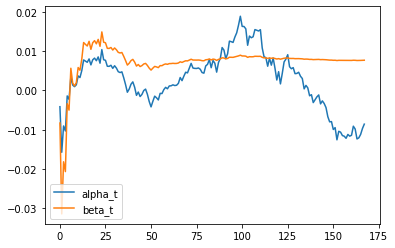

In [203]:
plt.plot(alpha_states, label = "alpha_t")
plt.plot(beta_states, label = "beta_t")
plt.legend(loc = "lower left")
plt.show()

### Excercise 3:

#### The file m-ppiaco4709.txt contains year, month, day, and U.S producer price index (PPI) from January 1947 to November 2009. The index is for all commodities and not seasonally adjusted. Let z_t = ln(Z_t) - ln(Z_t-1), where Z_t is the observed monthly PPI. It turns out that an AR(3) model is adequate for z_t, if the minor seasonal dependence is ignored. Let y_t, be the sample mean-corrected series of z_t.

#### a) Fit an AR(3) model to y_t, and write down the fitted model

In [205]:
ppi_data = pd.read_csv(r"C:\Users\zawilaniedzwiecki.p\OneDrive - Procter and Gamble\Desktop\ppiaco.csv")

First 5 observations of log_ppi_data:         PPI
0  3.198673
1  3.206803
2  3.230804
3  3.222868
4  3.218876


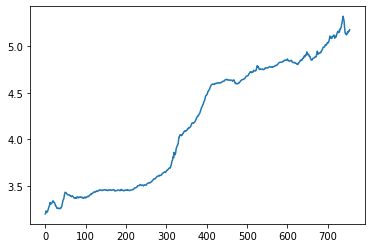

In [223]:
log_ppi_data = np.log(ppi_data)

print(f"First 5 observations of log_ppi_data: {log_ppi_data[:5]}")
plt.plot(log_ppi_data)
plt.show()

Let's calculate the new z_t variable:

First 5 observations of z_t: 0   -0.008130
1   -0.024001
2    0.007937
3    0.003992
4    0.000000
dtype: float64
Mean of z_t: -0.002627882781976027


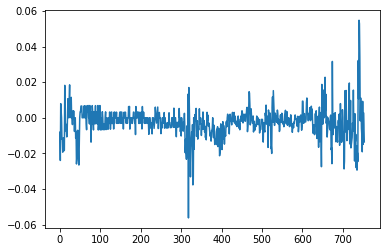

In [228]:
list_log_ppi_data = list(log_ppi_data["PPI"])
del list_log_ppi_data[0]
list_log_ppi_data.append(0)
moved_log_ppi_data = pd.Series(list_log_ppi_data)
z_t = (log_ppi_data["PPI"] - moved_log_ppi_data).drop(labels = [754])

print(f"First 5 observations of z_t: {z_t[:5]}")
print(f"Mean of z_t: {np.mean(z_t)}")
plt.plot(z_t)
plt.show()

First 5 observations of y_t: 0   -0.005502
1   -0.021373
2    0.010564
3    0.006620
4    0.002628
dtype: float64
Mean of y_t process: -2.6688053476566264e-18


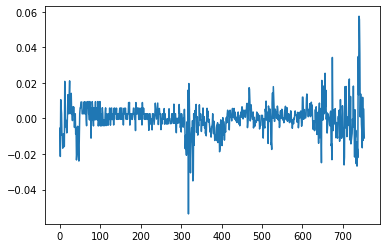

In [236]:
y_t = z_t - np.mean(z_t)

print(f"First 5 observations of y_t: {y_t[:5]}")
print(f"Mean of y_t process: {np.mean(y_t)}")
plt.plot(y_t)
plt.show()

With how small mean of the z_t is, mean subtraction makes the plots of z_t and y_t nearly indistinguishable. Mean not being equal to zero is standard case of float point precision.

In [235]:
ARMA_model = ARMA(y_t, order = (3,0))
fitted_ARMA_model = ARMA_model.fit()
print(fitted_ARMA_model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  754
Model:                     ARMA(3, 0)   Log Likelihood                2587.236
Method:                       css-mle   S.D. of innovations              0.008
Date:                Sun, 24 May 2020   AIC                          -5164.472
Time:                        17:22:53   BIC                          -5141.345
Sample:                             0   HQIC                         -5155.563
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.075e-05      0.001     -0.054      0.957      -0.001       0.001
ar.L1.y        0.2873      0.036      7.916      0.000       0.216       0.358
ar.L2.y        0.1226      0.038      3.252      0.0

#### b) Suppose that y_t has independent measuremenet errors so that y_t = x_t + e_t, where x_t is a zero-mean AR(3) process, and Var(e_t) = sigma_e^2. Use a state-space form to estimate the parameters, including the innovational variances to the state and sigma_e^2. Write down the fitted model and obtain a time plot of the smoothed estimate of x_t. Also, show the time plot of the filtered response residuals of the fitted state space model.

For this part of exercise, we will again use the same approach with creating our own state space classes, using the equations from the lecture 10 given in Example 11.2. I will let myself initiate any kind of theta parameters.

In [240]:
class StateAR3Model(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, theta):
        # Model order
        k_states = k_posdef = 3

        # Initialize the statespace
        super(StateAR3Model, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([0,0,1])
        self.ssm['transition'] = np.array([[0, 1, 0],
                                           [0, 0, 1],
                                           [theta[0], theta[1], theta[2]]])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.e', 'sigma2.lag1', 'sigma2.lag2', 'sigma2.lag3']

    @property
    def start_params(self):
        return [np.std(self.endog)]*4

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(StateAR3Model, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

In [242]:
theta = [0.5, 0.5, 0.5]
state_AR_model = StateAR3Model(pfizer_stock_data, theta)
fitted_state_AR_model = state_AR_model.fit()
print(fitted_state_AR_model.summary())

                           Statespace Model Results                           
Dep. Variable:                returns   No. Observations:                  168
Model:                  StateAR3Model   Log Likelihood                 154.769
Date:                Sun, 24 May 2020   AIC                           -301.538
Time:                        17:36:25   BIC                           -289.114
Sample:                             0   HQIC                          -296.494
                                - 168                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sigma2.e        0.0046      0.001      3.278      0.001       0.002       0.007
sigma2.lag1     0.0065      0.001      9.902      0.000       0.005       0.008
sigma2.lag2  2.059e-11      0.003   7.84e-09    

From above we can read the variances, and fitted model. Let's plot the smoothed estimate of x_t:

In [244]:
fitted_state_AR_model.filter_results.filtered_state

array([[ 0.        , -0.126     , -0.02076   , -0.13692784,  0.0815596 ,
        -0.02485942,  0.05540426,  0.02007256,  0.03859189,  0.00512421,
         0.03301389,  0.03297646,  0.05775798,  0.06238774,  0.07448902,
         0.07716714,  0.05147229,  0.03510575,  0.0634845 ,  0.03115551,
         0.05503248,  0.05630897,  0.01444797,  0.08958708,  0.01092876,
         0.07276659, -0.01893445,  0.01346832,  0.01033738,  0.00579375,
         0.02790371,  0.00542492,  0.01613251,  0.00236503,  0.00264624,
        -0.00262231, -0.01804453, -0.05506148, -0.03314352, -0.01639447,
         0.02137675,  0.00938992, -0.0180501 , -0.01579969, -0.03401821,
         0.00920382, -0.00375936,  0.02095211,  0.01408985, -0.01636085,
        -0.03860203, -0.01894537, -0.00063394,  0.02052981,  0.01263379,
         0.017208  ,  0.01829233,  0.04906785,  0.02986495,  0.03621377,
         0.04022051,  0.0234741 ,  0.03816693,  0.02477378,  0.02443192,
         0.02637547,  0.04005734,  0.03099116,  0.0

As our x_t is sum of states with weights given by theta (as per first equation in Example 11.2), let's calculate it:

In [249]:
first_states = fitted_state_AR_model.filter_results.filtered_state[0]
second_states = fitted_state_AR_model.filter_results.filtered_state[1]
third_states = fitted_state_AR_model.filter_results.filtered_state[2]

estimated_x_t = first_states*theta[0]+second_states*theta[1]+third_states*theta[2]

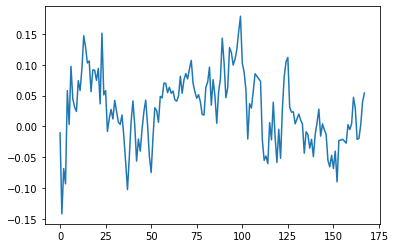

In [251]:
plt.plot(estimated_x_t)
plt.show()

Let's now plot residuals of the fitted model:

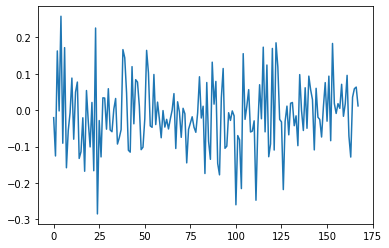

In [255]:
residuals = fitted_state_AR_model.resid
plt.plot(residuals)
plt.show()